In [178]:
import torch
import numpy as np
import utils.gradientUtils as gu
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

#cuda devices
device = torch.device("cuda:0")
print("Using device: ", torch.cuda.get_device_name(device))


threshold = 1e-6
max_iter = 2000
learning_rate = 0.03

radius = 3.0
origin=torch.tensor([5.0, 5.0], device=device)
side_length=4.0

sdf = 'circle'
sdf = 'thorus'
#sdf = 'box'


destination = "./images/autograd/multiple_sites/"

Using device:  NVIDIA GeForce RTX 3050 Laptop GPU


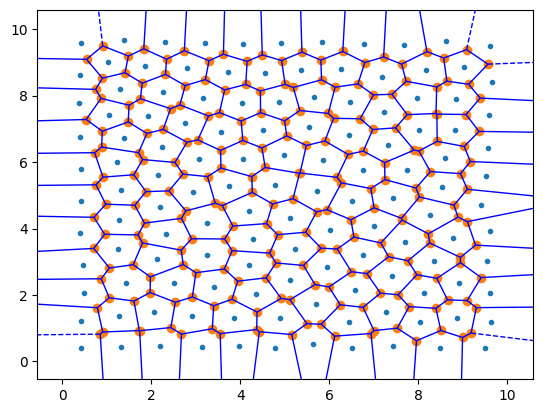

In [179]:
# Python code for creating a CVT
# Vassilis Vassiliades - Inria, Nancy - April 2018

import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn.cluster import KMeans
import argparse

# Default values
num_centroids = 128
dimensionality = 2
num_samples = 100000
num_replicates = 1
max_iterations = 100000
tolerance = 0.00001
verbose = True

X = np.random.rand(num_samples,dimensionality)

kmeans = KMeans(
    init='k-means++', 
    n_clusters=num_centroids, 
    n_init=num_replicates, 
    #n_jobs=-1, 
    max_iter=max_iterations, 
    tol=tolerance,
    verbose=0)

kmeans.fit(X)
centroids = kmeans.cluster_centers_
vor = Voronoi(centroids*10)
fig, ax = plt.subplots()
voronoi_plot_2d(vor, ax=ax, show_vertices=True, line_colors='blue')
# Plot the points
#plt.savefig('CVT_'f'{num_centroids}''.png',transparent=True)
plt.show()


In [180]:
centroids = np.array(centroids) * 10.0
sites = torch.from_numpy(centroids).to(device).requires_grad_(True)


#torch.manual_seed(30)
#sites = torch.rand(11, 2, dtype=torch.float32,device=device, requires_grad=True)

#sites = sites * 10.0
#print(sites)


In [181]:
def get_delaunay_neighbors_list(sites):
    # Detach and convert to NumPy for Delaunay triangulation
    points_np = sites.detach().cpu().numpy()
    
    # Compute the Delaunay triangulation
    tri = Delaunay(points_np)

    # Find the neighbors of each point
    neighbors = {i: set() for i in range(len(points_np))}
    for simplex in tri.simplices:
        # Each simplex is a triangle of three points; each point is a neighbor of the other two
        for i in range(3):
            for j in range(i + 1, 3):
                neighbors[simplex[i]].add(simplex[j])
                neighbors[simplex[j]].add(simplex[i])

    # Convert neighbor sets to lists for easier reading
    neighbors = {key: list(value) for key, value in neighbors.items()}
    return neighbors


In [182]:
def compute_vertices_index(neighbors):
    vertices_index_to_compute = []
    for site, adjacents in neighbors.items():
        for i in adjacents:
            for n in adjacents:
                if n != site and n != i and n in neighbors[i]:              
                    vertices_index_to_compute.append([i,site,n])
            
    # Set to store the canonical (sorted) version of each triplet
    seen_triplets = set()
    # Filtered list to store the unique triplets
    filtered_triplets = []
    # Process each triplet and keep only one permutation
    for triplet in vertices_index_to_compute:
        # Convert the triplet to a canonical form by sorting it
        canonical_triplet = tuple(sorted(triplet, key=str))
        # Check if this canonical triplet has been seen before
        if canonical_triplet not in seen_triplets:
            # If not seen, add it to the set and keep the triplet
            seen_triplets.add(canonical_triplet)
            filtered_triplets.append(triplet)

    return filtered_triplets

In [183]:
def compute_vertex(s_i, s_j, s_k):
    # Unpack coordinates for each site
    x_i, y_i = s_i[0], s_i[1]
    x_j, y_j = s_j[0], s_j[1]
    x_k, y_k = s_k[0], s_k[1]
    
    # Calculate numerator and  for x coordinate
    n_x = (
        x_i**2 * (y_j - y_k)
        - x_j**2 * (y_i - y_k)
        + (x_k**2 + (y_i - y_k) * (y_j - y_k)) * (y_i - y_j)
    )

    # Calculate numerator for y coordinate
    n_y = -(
        x_i**2 * (x_j - x_k)
        - x_i * (x_j**2 - x_k**2 + y_j**2 - y_k**2)
        + x_j**2 * x_k
        - x_j * (x_k**2 - y_i**2 + y_k**2)
        - x_k * (y_i**2 - y_j**2)
    )
    
    # Calculate denominator 
    d = 2 * (x_i * (y_j - y_k) - x_j * (y_i - y_k) + x_k * (y_i - y_j))
    
    # Calculate x and y coordinates
    x = n_x / d
    y = n_y / d

    # Return x, y as a tensor to maintain the computational graph
    return torch.stack([x, y])


In [184]:
def circle_sdf_loss(vertices, radius=3.0, origin=torch.tensor([0.0, 0.0])):
    # Calculate the Euclidean distance of each vertex to the specified origin
    distances = torch.norm(vertices - origin, dim=1)  # L2 norm along x and y for each vertex
    
    # Calculate the SDF value: distance to origin minus the circle radius
    sdf_values = distances - radius
    return sdf_values


In [185]:
def torus_sdf_loss(vertices, r_inner=1.0, r_outer=3.0, origin=torch.tensor([0.0, 0.0])):
    """
    Compute the SDF loss for a 2D torus (ring) given a set of vertices.

    Parameters:
        vertices (torch.Tensor): Tensor of shape (N, 2), where each row is a 2D vertex.
        r_inner (float): Inner radius of the torus (ring).
        r_outer (float): Outer radius of the torus (ring).
        origin (torch.Tensor): Origin of the torus (center), a tensor of shape (2,).

    Returns:
        torch.Tensor: Signed distance values for each vertex, shape (N,).
    """
    # Calculate the Euclidean distance of each vertex to the torus origin
    distances_to_center = torch.norm(vertices - origin, dim=1)  # L2 norm along x and y for each vertex

    # Compute the unsigned distance to the ring
    unsigned_distance = torch.abs(distances_to_center - r_outer)
    
    # Compute the SDF
    sdf_values = unsigned_distance - (r_outer - r_inner)
    
    return sdf_values


In [186]:
def zerocrossing_optim(neighbors, sites):
    filtered_triplets = compute_vertices_index(neighbors)

    # List to store unique pairs of neighboring triplets with zero-crossing SDF values
    sdf_filtered_triplets = []
    # Set to track unique triplets that have already been added
    seen_triplets = set()
    
    for i in range(len(filtered_triplets)):
        count = 0
        triplet_a = set(filtered_triplets[i])
        
        for j in range(i + 1, len(filtered_triplets)):
            triplet_b = set(filtered_triplets[j])
            if count == 3:
                break
            if len(triplet_a.intersection(triplet_b)) == 2:
                vertices = [
                    compute_vertex(sites[filtered_triplets[i][0]], sites[filtered_triplets[i][1]], sites[filtered_triplets[i][2]]),
                    compute_vertex(sites[filtered_triplets[j][0]], sites[filtered_triplets[j][1]], sites[filtered_triplets[j][2]])
                ]
                vertices = torch.stack(vertices)
                
                #sdf_ab = circle_sdf_loss(vertices, radius=radius, origin=origin)
                sdf_ab = torus_sdf_loss(vertices, origin=origin)
                
                #zero et negtif pour la selection todo
                #better
                if sdf_ab[0] * sdf_ab[1] <= 0 :
                #if sdf_ab[0] * sdf_ab[1] < 0 :
                    
                    count += 1
                    triplet_a_tuple = tuple(sorted(filtered_triplets[i]))
                    triplet_b_tuple = tuple(sorted(filtered_triplets[j]))
                    
                    if triplet_a_tuple not in seen_triplets:
                        sdf_filtered_triplets.append(filtered_triplets[i])
                        seen_triplets.add(triplet_a_tuple)
                        
                    if triplet_b_tuple not in seen_triplets:
                        sdf_filtered_triplets.append(filtered_triplets[j])
                        seen_triplets.add(triplet_b_tuple)

    return sdf_filtered_triplets


In [187]:
def compute_all_vertices(sites, vertices_to_compute):
    # Initialize an empty tensor for storing vertices
    vertices = []
    
    for triplet in vertices_to_compute:
        si = sites[triplet[0]]
        sj = sites[triplet[1]]
        sk = sites[triplet[2]]
        
        # Compute vertex for the triplet (si, sj, sk)
        v = compute_vertex(si, sj, sk)
        
        # Append to the list
        vertices.append(v)
    
    # Stack the list of vertices into a single tensor for easier gradient tracking
    vertices = torch.stack(vertices)
    return vertices


In [188]:
def box_sdf_loss(vertices, side_length=4.0):
    # Calculate half side length (since box is centered at origin)
    half_side = side_length / 2.0
    
    # Compute the signed distance to the box for each vertex
    dx = torch.clamp(torch.abs(vertices[:, 0]) - half_side, min=0)  # Distance from x-axis bounds
    dy = torch.clamp(torch.abs(vertices[:, 1]) - half_side, min=0)  # Distance from y-axis bounds
    
    # Calculate the SDF as the Euclidean distance from the nearest box boundary
    sdf_values = torch.sqrt(dx**2 + dy**2)
    return sdf_values


In [189]:
def min_distance_regularization(sites):
    # Compute pairwise distances between all sites
    distances = torch.cdist(sites, sites, p=2)
    
    # Create a mask to ignore distances between a site and itself
    mask = torch.eye(distances.size(0), device=distances.device).bool()
    distances = distances.masked_fill(mask, float("inf"))

    # Calculate minimum distance for each site
    min_distances = distances.min(dim=1).values  # Minimum distance to another site for each site

    # Calculate the average of these minimum distances
    avg_min_distance = min_distances.mean()

    # Calculate penalties based on the condition provided
    #penalties = torch.clamp(min_distances - avg_min_distance, min=0)

    penalties = min_distances - avg_min_distance


    # Sum the penalties to get the regularization loss
    regularization_loss = torch.mean(torch.sum(penalties**2))
    
    return regularization_loss



In [190]:
def min_distance_regularization_for_opsites(sites, vertices_to_compute):
    
    # Extract unique indices from the triplets
    unique_indices = torch.unique(torch.tensor(vertices_to_compute).flatten())

    # Select sites corresponding to unique indices
    sites_optimized = torch.stack([sites[i] for i in unique_indices])
    
    # Compute pairwise distances between all sites
    distances = torch.cdist(sites_optimized, sites_optimized, p=2)
    
    # Create a mask to ignore distances between a site and itself
    mask = torch.eye(distances.size(0), device=distances.device).bool()
    distances = distances.masked_fill(mask, float("inf"))

    # Calculate minimum distance for each site
    min_distances = distances.min(dim=1).values  # Minimum distance to another site for each site

    # Calculate the average of these minimum distances
    avg_min_distance = min_distances.mean()

    # Calculate penalties based on the condition provided
    #penalties = torch.clamp(min_distances - avg_min_distance, min=0)

    penalties = min_distances - avg_min_distance


    # Sum the penalties to get the regularization loss
    regularization_loss = torch.mean(torch.sum(penalties**2))
    
    return regularization_loss

In [191]:
# def create_dynamic_mask(sdf_values):
#     # Calculate the mean and standard deviation of the SDF values
#     mean_sdf = sdf_values.mean()
#     std_sdf = sdf_values.std()
    
#     # Define a dynamic threshold based on the mean and standard deviation
#     # For example, consider vertices within one standard deviation of the mean
#     lower_threshold = mean_sdf - std_sdf
#     upper_threshold = mean_sdf + std_sdf
    
#     # Create a mask where SDF values fall within the dynamic range
#     mask = (sdf_values > lower_threshold) & (sdf_values < upper_threshold)
    
#     return mask.float()  # Convert boolean mask to float for further use


In [192]:
def compute_cvt_loss(sites):
    # Compute the Voronoi diagram based on the current site locations
    vor = Voronoi(sites.detach().cpu().numpy())
    
    centroids = []
    for i in range(len(sites)):
        # Find the region corresponding to the current site
        region_index = vor.point_region[i]
        region = vor.regions[region_index]
        
        # Check if the region is valid (i.e., finite and non-empty)
        if -1 not in region and len(region) > 0:
            # Compute the centroid as the mean of the vertices in this region
            vertices = vor.vertices[region]
            centroid = vertices.mean(axis=0)
        else:
            # For regions that are unbounded, return the site itself as the centroid
            centroid = sites[i].detach().cpu().numpy()
        
        centroids.append(centroid)
    
    centroids = torch.tensor(centroids, device=sites.device)
    
    # Calculate the CVT loss using Mean Squared Error
    cvt_loss = torch.mean(torch.norm(sites - centroids, p=2, dim=1) ** 2)
    
    return cvt_loss

In [193]:
def plot_sdf(ax):
    #plot the sdf function
    if sdf == 'circle':
        circle = plt.Circle(origin.detach().cpu().numpy(), radius, color='black', fill=False, label='True SDF')
        ax.add_artist(circle)
    elif sdf == 'box':
        rect = plt.Rectangle((5, 5), side_length, side_length/2, fill=False, color='black', label='True SDF')
        ax.add_artist(rect)
    elif sdf == 'thorus':
        inner_circle = plt.Circle(origin.detach().cpu().numpy(), 1.0, color='black', fill=False, label='inner circle')
        outer_circle = plt.Circle(origin.detach().cpu().numpy(), 5.0, color='black', fill=False, label='outer circle')
        ax.add_artist(inner_circle)
        ax.add_artist(outer_circle)    


def plot_torus_2d(r_inner=0.5, r_outer=1.0, origin=np.array([0.0, 0.0]), num_points=500):
    """
    Plots a 2D torus (ring) defined by inner and outer radii.

    Parameters:
        r_inner (float): Inner radius of the torus.
        r_outer (float): Outer radius of the torus.
        origin (array-like): Center of the torus as a 2D array [x, y].
        num_points (int): Number of points to plot for each circle.
    """
    # Generate angles for the parametric circle
    theta = np.linspace(0, 2 * np.pi, num_points)
    
    # Outer circle
    outer_x = origin[0] + r_outer * np.cos(theta)
    outer_y = origin[1] + r_outer * np.sin(theta)
    
    # Inner circle
    inner_x = origin[0] + r_inner * np.cos(theta)
    inner_y = origin[1] + r_inner * np.sin(theta)
    
    # Plotting
    plt.figure(figsize=(6, 6))
    plt.plot(outer_x, outer_y, label="Outer Boundary", color="blue")
    plt.plot(inner_x, inner_y, label="Inner Boundary", color="red")
    
    # Fill the area between the circles
    plt.fill_betweenx(outer_y, inner_x, outer_x, where=inner_x < outer_x, color='cyan', alpha=0.3, label="Torus Region")
    
    # Aesthetics
    plt.gca().set_aspect('equal', adjustable='box')  # Equal scaling
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
    plt.title("2D Torus (Ring)")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.legend()
    plt.grid(alpha=0.3)
#    plt.show()


In [194]:
#perform guided upsampling
def sdf_sign_consistency(sdf_values):
    """Check if all SDF values have the same sign for a tensor."""
    return torch.all(sdf_values > 0) or torch.all(sdf_values < 0)


def detect_cells_for_upsampling(sites, zero_crossing_tol=0.05):
    """
    Detect Voronoi cells that need upsampling based on SDF consistency and zero-crossing proximity.
    
    Parameters:
        sites (ndarray): Current Voronoi seed points (Nx2 array for 2D).
        sdf_func (function): Signed Distance Function (SDF) for the space.
        zero_crossing_tol (float): Tolerance for identifying zero-crossings.
        radius (float): Radius for placing new sites around the current site.
    
    Returns:
        new_sites (list): List of new site coordinates for upsampling.
    """
    np_sites = sites.detach().cpu().numpy()
    vor = Voronoi(np_sites)
    new_sites = []

    for i, region_index in enumerate(vor.point_region):
        region = vor.regions[region_index]
        if -1 in region or len(region) == 0:  # Skip infinite or empty regions
            continue
        
        
        # Get vertices of the cell
        #vertices = vor.vertices[region]
        #create tensor from numpy array
        vertices = torch.from_numpy(vor.vertices[region]).to(device)
        # Evaluate SDF at vertices
        #sdf_values = np.array([sdf_func(v) for v in vertices])
        
        #sdf_values = circle_sdf_loss(vertices, radius=radius, origin=origin)
        sdf_values = torus_sdf_loss(vertices, origin=origin)

        
        
        # Skip cell if all SDF values have the same sign
        if sdf_sign_consistency(sdf_values):
            continue


        smallest_edge_length = float("inf")
        
        # Check edges for zero-crossing proximity
        edges_cross_zero = 0
        for j in range(len(vertices)):
            v1, v2 = vertices[j], vertices[(j + 1) % len(vertices)]
            
            # Compute edge length
            edge_length = torch.norm(v2 - v1)
            smallest_edge_length = min(smallest_edge_length, edge_length)
            
            # Check if SDF values at edge vertices are within the zero-crossing tolerance
            sdf_v1, sdf_v2 = sdf_values[j], sdf_values[(j + 1) % len(vertices)]
            if abs(sdf_v1) < zero_crossing_tol and abs(sdf_v2) < zero_crossing_tol:
                edges_cross_zero += 1
                
        
        # # Skip cell if only one edge is within the zero-crossing tolerance
        # if edges_cross_zero == 1:
        #     continue

        # Upsample: Add 3 new sites around the current site
        current_site = sites[i]
        
        # for _ in range(3):
        #     # Generate new sites around the current site within a small radius
        #     angle = np.random.uniform(0, 2 * np.pi)
        #     offset = np.array([np.cos(angle), np.sin(angle)]) 
        #     offset = torch.from_numpy(offset).to(device)
        #     offset = offset * smallest_edge_length
            
        #     new_sites.append(current_site + offset)


        # Calculate the distance from the barycenter to the vertices (circumradius)
        rad = smallest_edge_length / np.sqrt(3)  # For equilateral triangle, circumradius = edge / sqrt(3)

        # Define 3 angles for the triangle vertices, spaced 120 degrees apart
        angles = torch.tensor([0, 2 * np.pi / 3, 4 * np.pi / 3], device=device)
        
        # Calculate the offset vectors for each vertex around the barycenter
        offsets = torch.stack([torch.cos(angles), torch.sin(angles)], dim=1) * rad
        
        # Generate new sites by adding the offsets to the current site
        for offset in offsets:
            new_sites.append(current_site + offset)
            

    return new_sites

def add_upsampled_sites(sites, new_sites, min_distance=0.1):
    """
    Add new sites while ensuring a minimum distance between points.
    Parameters:
        sites (torch.Tensor): Existing sites, shape (N, 2).
        new_sites (torch.Tensor): New candidate sites, shape (M, 2).
        min_distance (float): Minimum allowable distance between sites.
    Returns:
        torch.Tensor: Updated set of sites.
    """
    #updated_sites = sites.clone()  # Clone the existing tensor to modify later
    updated_sites = sites
    
    for new_site in new_sites:
        # Compute distances between the new site and all existing sites
        distances = torch.norm(updated_sites - new_site, dim=1)
        # Check if the new site is far enough from all existing sites
        if torch.all(distances > min_distance):
            #print(f"Adding new site at {new_site}")
            updated_sites = torch.cat((updated_sites, new_site.unsqueeze(0)), dim=0)

    return updated_sites

In [195]:
def autograd(sites, learning_rate=learning_rate, max_iter=max_iter, threshold=threshold, radius=radius):
    optimizer = torch.optim.Adam([sites], lr=learning_rate)
    prev_loss = float("inf")
    best_loss = float("inf")
    best_loss_upsampled = float("inf")
    upsampled = False
    epoch = 0
    lambda_cvt = 1.0
    lambda_sdf = 2.0
    lambda_min_distance = 0.1
    
    while epoch < max_iter:
        optimizer.zero_grad()
        
       
        neighbors = get_delaunay_neighbors_list(sites)
        vertices_to_compute = zerocrossing_optim(neighbors, sites)
        vertices = compute_all_vertices(sites, vertices_to_compute)

        if sdf == 'circle':
            sdf_values = circle_sdf_loss(vertices, radius=radius, origin=origin)
        elif sdf == 'box':
            sdf_values = box_sdf_loss(vertices)
        elif sdf == 'thorus':
            sdf_values = torus_sdf_loss(vertices, origin=origin)
            
        
        #sdf_mask = create_dynamic_mask(sdf_values)
        #masked_loss = (sdf_values ** 2 * sdf_mask).sum() / sdf_mask.sum()  # Normalize by the number of selected vertices
               
        # regularization loss        
        #min_distance_loss = min_distance_regularization(sites)
        min_distance_loss = min_distance_regularization_for_opsites(sites, vertices_to_compute)
        
        
        #cvt loss
        cvt_loss = compute_cvt_loss(sites)
        
        # Total loss
        #loss = masked_loss + min_distance_loss
        loss = lambda_sdf*torch.mean(sdf_values**2) + lambda_cvt*cvt_loss + lambda_min_distance*min_distance_loss 

        loss.backward()
        optimizer.step()
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_epoch = epoch
            best_sites = sites.clone()
            if upsampled:
                print(f"UPSAMPLED Best Epoch {best_epoch}: Best loss = {best_loss}")
                #return best_sites
        


        if abs(prev_loss - loss.item()) < threshold:
            break
        prev_loss = loss.item() 
        
        if epoch == max_iter/2:
            print("sites length: ",len(sites))
            new_sites = detect_cells_for_upsampling(best_sites, zero_crossing_tol=0.05)
            sites = add_upsampled_sites(best_sites, new_sites, min_distance=0.01)
            sites = sites.detach().requires_grad_(True)
            print("upsampled sites length: ",len(sites))
            
            best_sites = sites.clone()
            
            optimizer = torch.optim.Adam([sites], lr=learning_rate)
            upsampled = True
            #lambda_cvt = 1.0
            #lambda_sdf = 3.0
            #lambda_min_distance = 0.1
            
            
            #best_loss = best_loss*1.5
            #max_iter += 1000

        
        if epoch % 100 == 0:
            #sites = best_sites
            #sites = sites.detach().requires_grad_(True)
            #optimizer = torch.optim.Adam([sites], lr=learning_rate)
            
            
            print(f"Epoch {epoch}: loss = {loss.item()}")
            print(f"Best Epoch {best_epoch}: Best loss = {best_loss}")
            
            print(vertices_to_compute)
            

            
            sites_np = sites.detach().cpu().numpy()
            tri = Delaunay(sites_np)
            voronoi_initial = Voronoi(sites_np)
            fig, ax = plt.subplots()
            voronoi_plot_2d(voronoi_initial, ax=ax, show_vertices=False, line_colors='blue')
            plot_sdf(ax)
            plt.xlim(0,10)
            plt.ylim(0,10)
            
            plt.title(f'Epoch {epoch}')
            if upsampled:
                plt.title(f'Epoch {epoch} - Upsampled')


            plt.savefig(f'{destination}multiple_'f'{sdf}_'f'{epoch}.png')
        
        
        
                
        epoch += 1
            
            
            
        
    return best_sites

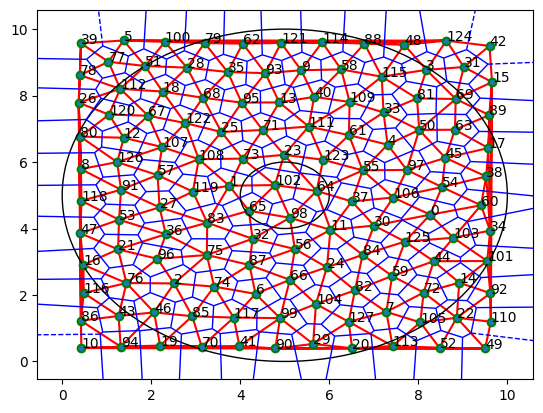

In [196]:
sites_np = sites.detach().cpu().numpy()
tri = Delaunay(sites_np)
voronoi_initial = Voronoi(sites_np)
fig, ax = plt.subplots()
voronoi_plot_2d(voronoi_initial, ax=ax, show_vertices=False, line_colors='blue')
ax.triplot(sites_np[:, 0], sites_np[:, 1], tri.simplices, color='red')
plt.scatter(sites_np[0, 0], sites_np[0, 1], color='blue')
plt.scatter(sites_np[:, 0], sites_np[:, 1], color='green')

#annotate the points with their index
for i, txt in enumerate(range(len(sites_np))):
    ax.annotate(txt, (sites_np[i, 0], sites_np[i, 1]))


plot_sdf(ax)

#scaled plot
#plt.xlim(-4,4)
#plt.ylim(-4,4)

plt.savefig(f'{destination}multiple_initial.png')

plt.show()

Epoch 0: loss = 389.2890750176683
Best Epoch 0: Best loss = 389.2890750176683
[[65, 1, 102], [65, 1, 83], [102, 1, 73], [73, 1, 108], [69, 3, 81], [69, 3, 31], [48, 3, 115], [48, 3, 124], [100, 5, 51], [100, 28, 51], [105, 7, 113], [105, 52, 113], [47, 8, 118], [118, 8, 91], [118, 47, 53], [80, 8, 26], [80, 8, 126], [114, 9, 121], [114, 100, 121], [64, 11, 98], [64, 11, 37], [98, 11, 56], [80, 12, 120], [80, 26, 120], [101, 14, 44], [101, 14, 92], [72, 14, 22], [22, 14, 92], [69, 15, 89], [69, 63, 89], [17, 15, 89], [89, 17, 63], [76, 16, 116], [116, 16, 86], [76, 43, 116], [47, 16, 21], [47, 16, 86], [34, 17, 38], [38, 17, 45], [112, 18, 51], [77, 51, 112], [94, 19, 46], [85, 19, 46], [94, 19, 70], [85, 19, 70], [113, 20, 52], [113, 20, 127], [90, 20, 29], [29, 20, 127], [99, 29, 90], [72, 22, 105], [105, 22, 52], [64, 23, 123], [111, 23, 123], [64, 55, 123], [102, 23, 73], [71, 23, 73], [112, 26, 120], [112, 67, 120], [100, 28, 79], [100, 79, 121], [65, 32, 98], [65, 32, 83], [98, 32

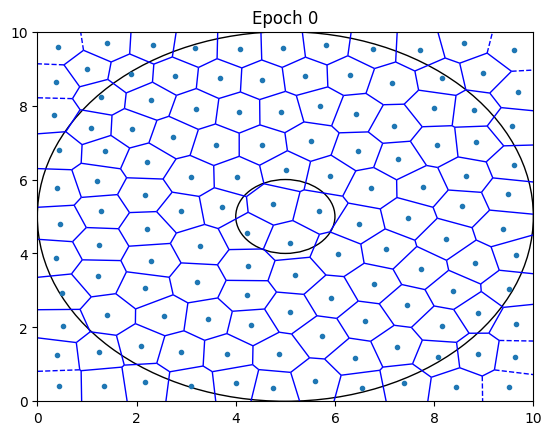

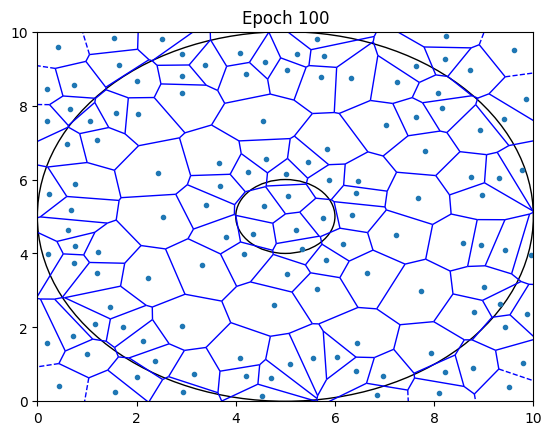

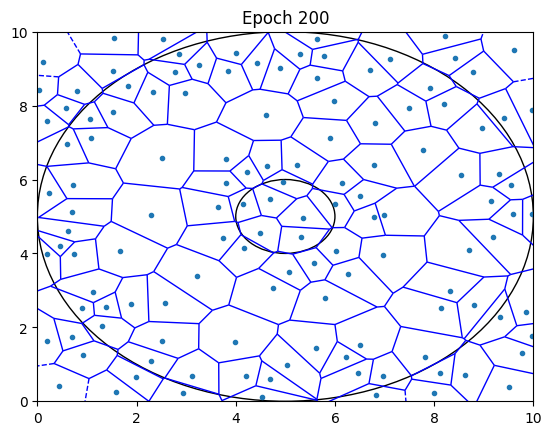

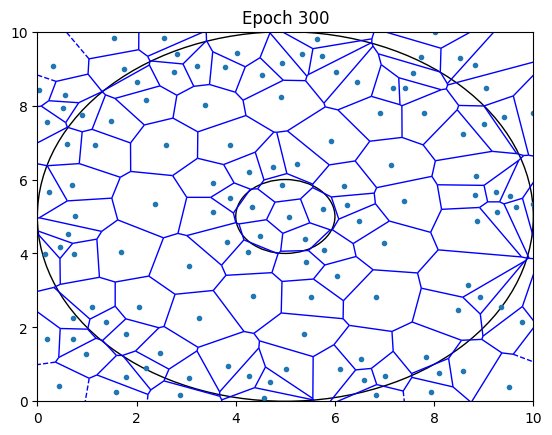

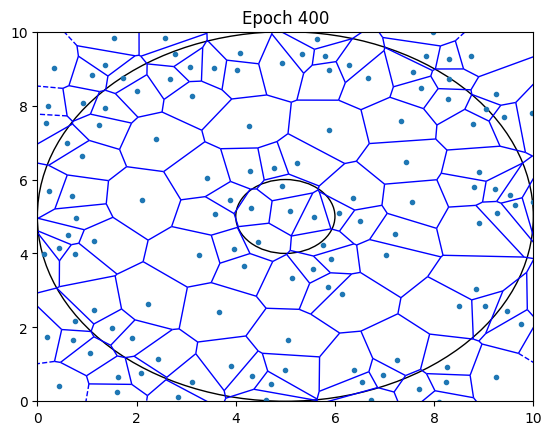

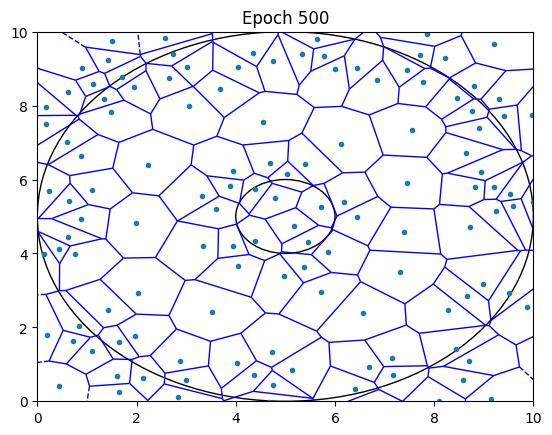

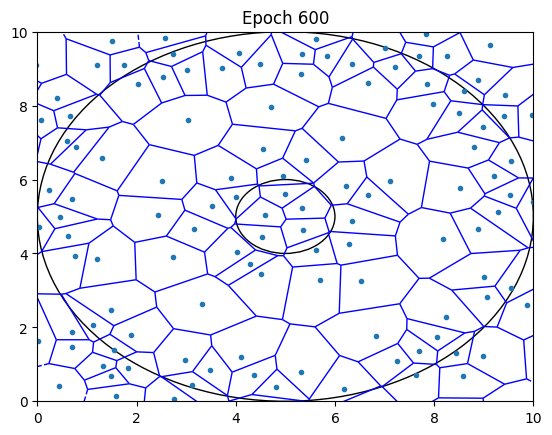

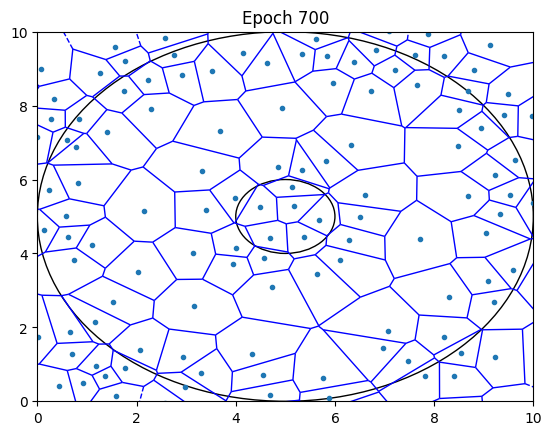

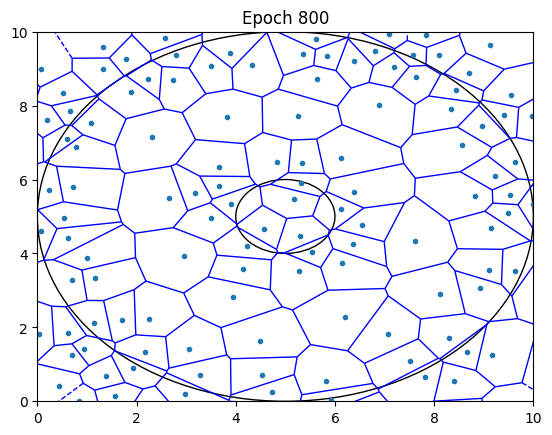

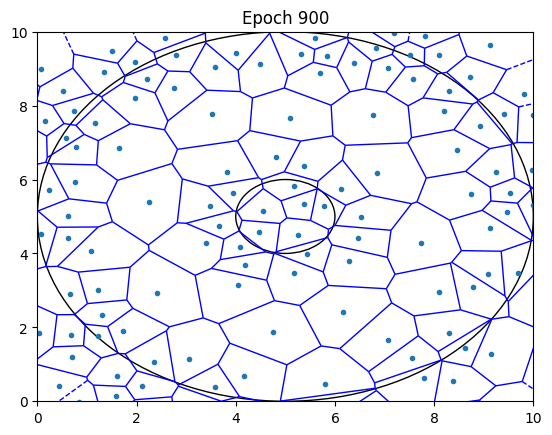

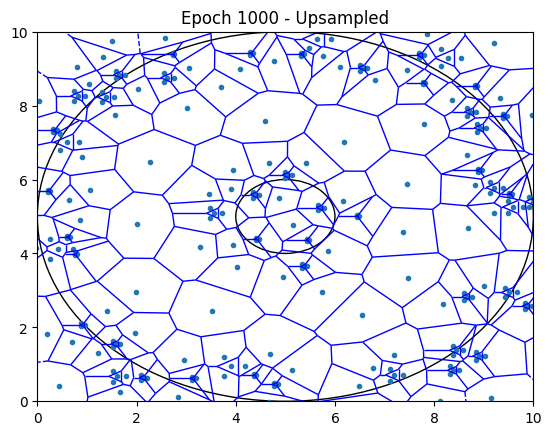

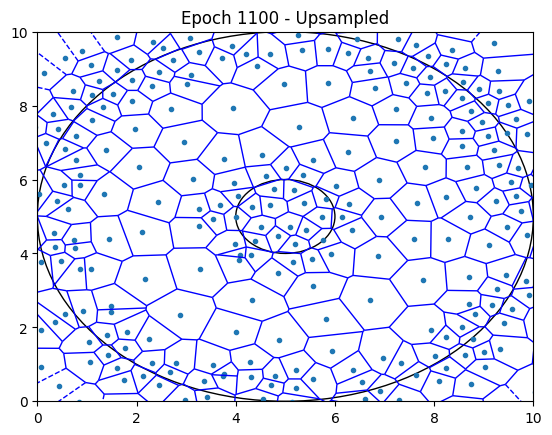

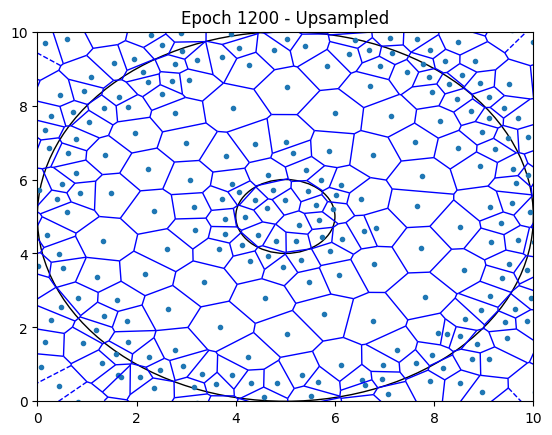

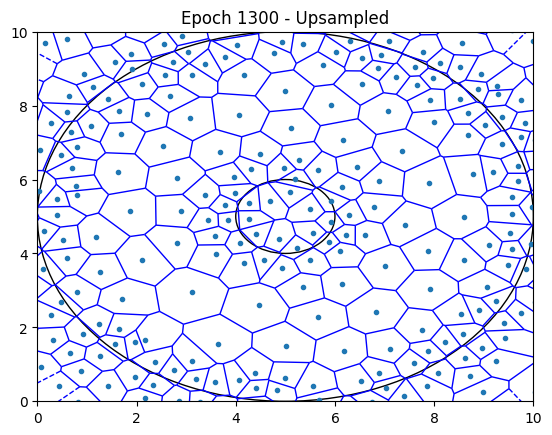

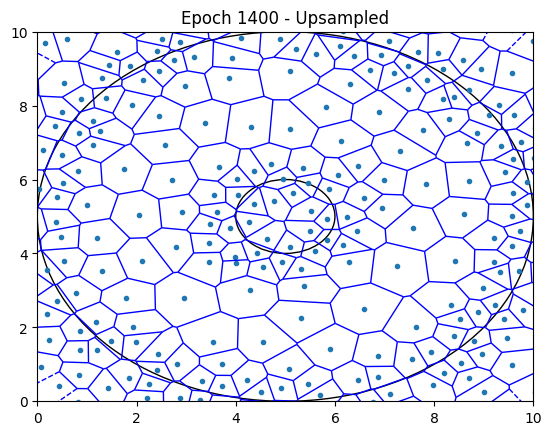

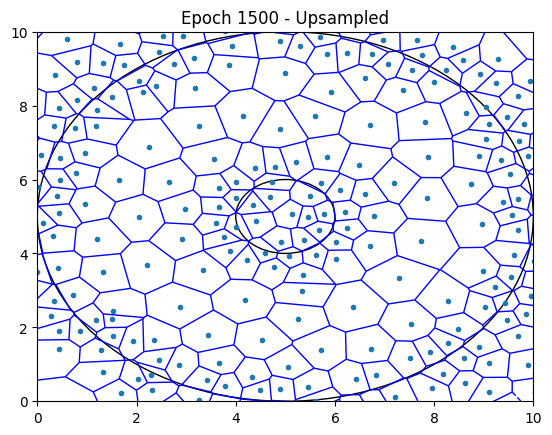

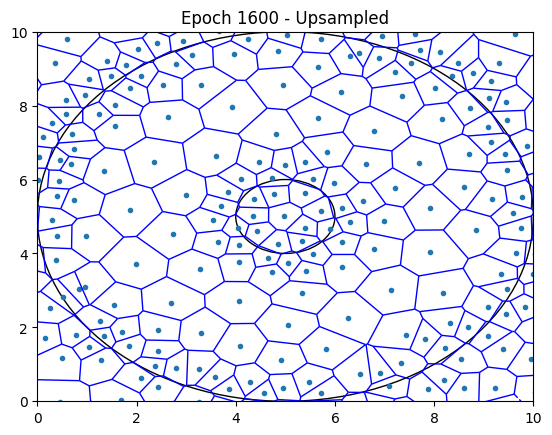

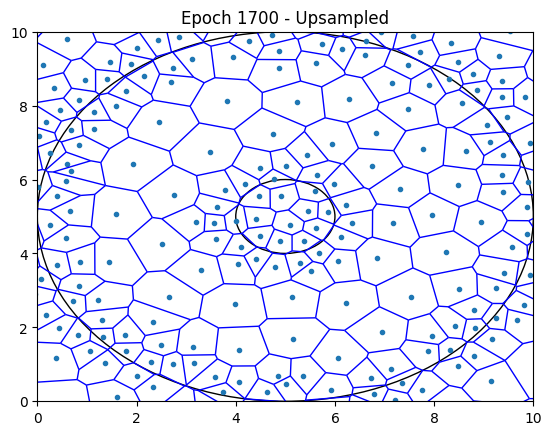

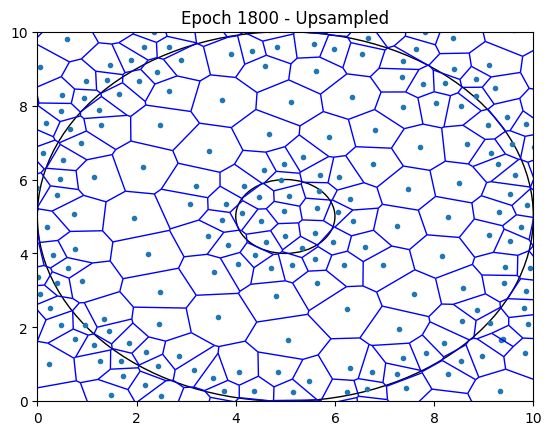

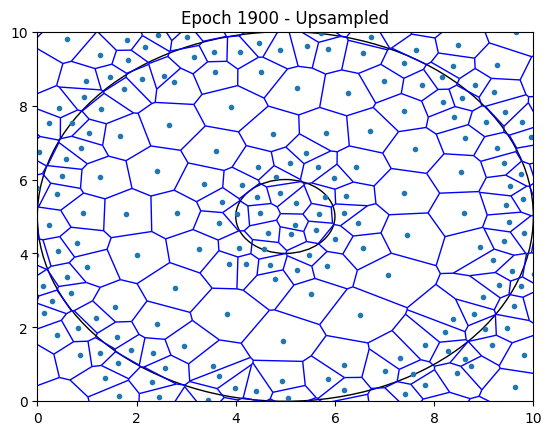

In [197]:
sites = autograd(sites)


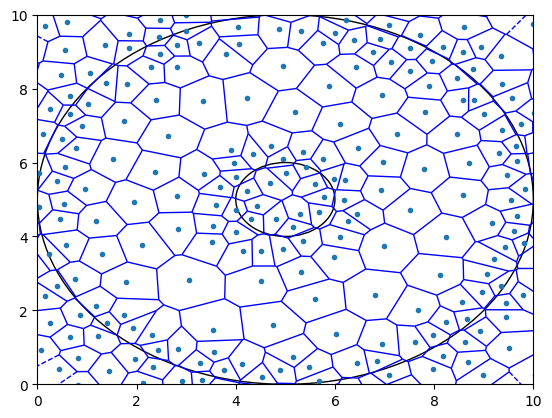

In [198]:
best_sites = sites.clone()
sites_np = sites.detach().cpu().numpy()
tri = Delaunay(sites_np)
voronoi_initial = Voronoi(sites_np)
fig, ax = plt.subplots()
voronoi_plot_2d(voronoi_initial, ax=ax, show_vertices=False, line_colors='blue')
#ax.triplot(sites_np[:, 0], sites_np[:, 1], tri.simplices, color='red')
# plt.scatter(sites_np[0, 0], sites_np[0, 1], color='blue')*-
# plt.scatter(sites_np[:, 0], sites_np[:, 1], color='green')
# 
# annotate the points with their index
# for i, txt in enumerate(range(len(sites_np))):
#     ax.annotate(txt, (sites_np[i, 0], sites_np[i, 1]))

plot_sdf(ax)
plt.xlim(0,10)
plt.ylim(0,10)


plt.savefig(f'{destination}multiple_'f'{sdf}_'f'{max_iter}.png')

plt.show()

In [199]:
# new_sites = detect_cells_for_upsampling(sites)
# #print(len(new_sites), new_sites)
# new_sites = torch.stack(new_sites)
# new_sites = new_sites.detach().requires_grad_(True)

# #updated_sites = add_upsampled_sites(sites, new_sites)
# #print(len(updated_sites), updated_sites)

# sites = autograd(new_sites)

In [200]:
# new_sites = detect_cells_for_upsampling(best_sites)
# #print(new_sites)

# updated_sites = add_upsampled_sites(best_sites, new_sites)

# updated_sites = updated_sites.detach().cpu().numpy()

# #print(len(sites))
# #print(len(updated_sites))

# voronoi_initial = Voronoi(updated_sites)
# fig, ax = plt.subplots()
# voronoi_plot_2d(voronoi_initial, ax=ax, show_vertices=False, line_colors='blue')
# #ax.triplot(sites_np[:, 0], sites_np[:, 1], tri.simplices, color='red')
# # plt.scatter(sites_np[0, 0], sites_np[0, 1], color='blue')
# # plt.scatter(sites_np[:, 0], sites_np[:, 1], color='green')
# # 
# # annotate the points with their index
# # for i, txt in enumerate(range(len(sites_np))):
# #     ax.annotate(txt, (sites_np[i, 0], sites_np[i, 1]))

# plot_sdf(ax)
# plt.xlim(0,10)
# plt.ylim(0,10)


# plt.savefig(f'{destination}multiple_'f'{sdf}_'f'{max_iter}.png')

# plt.show()

131
104


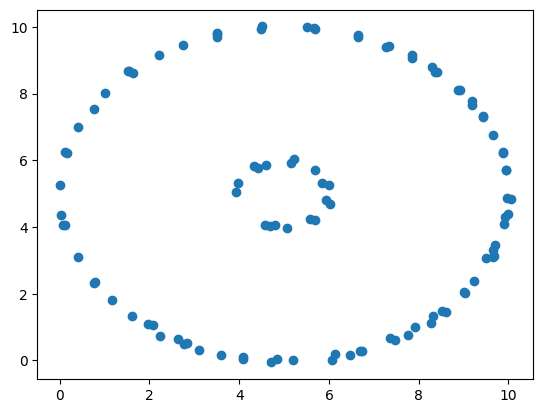

In [201]:
def extract_vertices_near_zero_crossing():
    neighbors = get_delaunay_neighbors_list(sites)
    vertices_to_compute = zerocrossing_optim(neighbors, sites)
    vertices = compute_all_vertices(sites,vertices_to_compute)

    vertices_np = vertices.detach().cpu().numpy()
    print(len(vertices_np))
    if sdf == 'circle':
        sdf_values = circle_sdf_loss(vertices, radius=radius, origin=origin)
    elif sdf == 'box':
        sdf_values = box_sdf_loss(vertices)
    elif sdf == 'thorus':
        sdf_values = torus_sdf_loss(vertices, origin=origin)
        
    #filter vertices based on sdf values
    vertices_to_mesh = []
    for i in range(len(vertices_np)):
        #if sdf values is around tolerance 
        if abs(sdf_values[i]) < 0.1:
            vertices_to_mesh.append(vertices_np[i])  

    print(len(vertices_to_mesh));




    # Convert vertices_to_mesh to a NumPy array
    vertices_to_mesh = np.array(vertices_to_mesh)

    #scatter vertices on a plot
    fig, ax = plt.subplots()
    plt.scatter(vertices_to_mesh[:,0],vertices_to_mesh[:,1])

extract_vertices_near_zero_crossing()

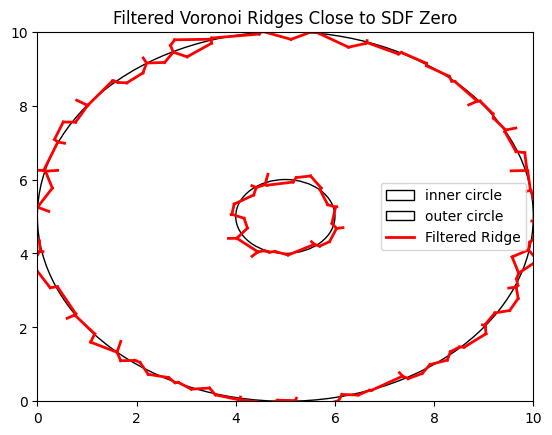

In [202]:
def plot_edges_near_zero_crossing():
    # Create Voronoi diagram
    sites_np = sites.detach().cpu().numpy()

    vor = Voronoi(sites_np)

    #create tensor from numpy array
    vertices = torch.from_numpy(vor.vertices).to(device)
    #sdf_values = circle_sdf_loss(vertices, radius=radius, origin=origin)
    sdf_values = torus_sdf_loss(vertices, origin=origin)
    
    
    # Tolerance for filtering
    tolerance = 0.3

    # Filter ridges based on SDF values of their vertices
    filtered_ridges = []
    for ridge in vor.ridge_vertices:
        # Skip ridges with infinite vertices (-1)
        if -1 in ridge:
            continue

        # Check if both vertices of the ridge are within tolerance
        if all(abs(sdf_values[vertex]) < tolerance for vertex in ridge):
            filtered_ridges.append(ridge)

    # Plot the filtered vertices and ridges
    fig, ax = plt.subplots()
    #voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='blue')
    plot_sdf(ax)
    
    plt.xlim(0,10)
    plt.ylim(0,10)


    # Plot sites
    #ax.plot(sites_np[:, 0], sites_np[:, 1], 'o', label='Sites')

    # Plot original Voronoi vertices
    #ax.plot(vor.vertices[:, 0], vor.vertices[:, 1], 'x', label='Voronoi Vertices')

    # Plot filtered ridges
    for ridge in filtered_ridges:
        v0, v1 = ridge
        ax.plot([vor.vertices[v0, 0], vor.vertices[v1, 0]],
                [vor.vertices[v0, 1], vor.vertices[v1, 1]], 'r-', lw=2, label='Filtered Ridge' if ridge == filtered_ridges[0] else None)

    plt.legend()
    plt.title('Filtered Voronoi Ridges Close to SDF Zero')
    plt.savefig(f'{destination}edge_sdf_crossing.png')

    plt.show()

plot_edges_near_zero_crossing()